<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка</a></span><ul class="toc-item"><li><span><a href="#Проверка-типов-полей" data-toc-modified-id="Проверка-типов-полей-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Проверка типов полей</a></span></li><li><span><a href="#Пропуски" data-toc-modified-id="Пропуски-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Пропуски</a></span></li><li><span><a href="#Дупликаты" data-toc-modified-id="Дупликаты-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Дупликаты</a></span></li></ul></li><li><span><a href="#Соединение-датафреймов" data-toc-modified-id="Соединение-датафреймов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Соединение датафреймов</a></span></li><li><span><a href="#Распределение-признаков-TRAIN" data-toc-modified-id="Распределение-признаков-TRAIN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Распределение признаков TRAIN</a></span></li><li><span><a href="#Распределение-признаков-TRAIN-в-разрезе-delay" data-toc-modified-id="Распределение-признаков-TRAIN-в-разрезе-delay-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Распределение признаков TRAIN в разрезе <code>delay</code></a></span></li><li><span><a href="#Анализ-корреляций-тренировочной-выборки" data-toc-modified-id="Анализ-корреляций-тренировочной-выборки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ корреляций тренировочной выборки</a></span></li><li><span><a href="#Пайплайн" data-toc-modified-id="Пайплайн-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Пайплайн</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li><li><span><a href="#Предсказание-на-тестовой-выборке" data-toc-modified-id="Предсказание-на-тестовой-выборке-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Предсказание на тестовой выборке</a></span></li></ul></div>

# Описание данных

Проводится анализ данных ипотечного кредитования одной компании. В компании уже есть модель для прогноза задержек по выплатам ипотеки, необходимо разработать модель, которая окажется лучше.

Для анализа предоставлены данные, хранящиеся в файлах `dataset.csv`, `spr_application.csv`, `spr_request.csv` и `spr_features.csv`.

`dataset.csv` содержит ретро данные, т.е. данные об уже закрытых кредитах, про которые известно, выплатили их или нет. Для каждой заявки имеются следующие данные:

* `application_id` - идентификатор заявки.
* `pd` (Probability of Default) - один из основных инструментов управления уровнем просрочки по кредитному портфелю.
* `initinal_payment` - первоначальный взнос/стоимость недвижимости (ПВ).
* `delay` - флаг просрочки (1 – просрочен, 0 – не просрочен).

`spr_application.csv` содержит данные о текущих кредитах, т.е. решение об их выдаче уже принято, но пока не известен `delay`. В таблице содержатся слелующие данные по каждой заявке:

* `application_id` - идентификатор заявки.
* `application_date` - дата заявки.
* `source` - видимо источник, откуда клиент пришел за ипотекой.

`spr_request.csv` содержит логи обработки заявок на ипотеку. Обработка проводится в 2 этапа - прескоринг и скоринг. Если на этапе прескоринга найдены данные по кредитной истории потенциального клиента (т.е. рассчитана `pd`), то проводится скоринг заявки. Если данных нет, то заявка отклоняется на этапе прескоринга. Прескоринг - SHORT_APPLICATION, скоринг - FULL_APPLICATION. Для каждого этапа обработки записываются следующие данные:

* `application_id` - идентификатор заявки.
* `spr_features_id` - ключ к данным по заявке из таблицы `spr_features.csv`.
* `create_date` - дата и время создания запроса.
* `request_type` - тип запроса, т.е. прескоринг (SHORT_APPLICATION) или скоринг (FULL_APPLICATION).
* `status` - решение модели по конкретной заявке. NEXT - переход с прескоринга на скоринг, DECLINE - отклонение заявки на этапе прескоринга или скоринга, APPROVE - одобрение заявки на этапе скоринга.

`spr_features.csv` - данные по заявкам для всех запросов из таблицы `spr_requst.csv`. Для прескоринга в таблице нет информации (просто пустые поля), для скоринга содержится информация о клиенте. Таблица состоит из следующих полей:

* `id` - идентификатор данных для каждого запроса. Необходим для получения данных о клиенте для каждого запроса.
* `dti` - неизвестное поле. В данные задаче не важно, что оно означает, т.к. в ретро данных этого поля нет.
* `pd` (Probability of Default) - один из основных инструментов управления уровнем просрочки по кредитному портфелю.
* `initinal_payment` - первоначальный взнос/стоимость недвижимости (ПВ).

# Описание задач

Требуется построить модель для предсказания того, вернет ли клиент кредит, т.е. предсказания столбца `delay`. Построенная модель должна удовлетворять следующим критериям: 

   1) Уровень просрочки по выдаваемым кредитам менее 1 % (не более 1 кредита из 100 будет просрочено)

   2) Уровень одобрения максимален при выполнении первого условия

Руководителем была выдвинута гипотеза, что отношение первоначального взносав к стоимости недвижимости (ПВ) хорошо ранжирует платежеспособность клинета (уровень просрочки).

Также необходимо:

   1)	Проверить гипотезу и составить аналитическую записку (ретро данные в файле `dataset.csv`);

   2)	Составить предложение по использованию ПВ в Системе Принятия Решения (СПР –автоматизированный набор методов проверки платежеспособности клиента, результатом работы которого является заключение: одобрить/отказать);

   3)	Оценить эффект на уровень одобрения от внедрения вашей инициативы (данные по актуальным заявкам в папке `БД`);

   4)	Составить бизнес-требование для разработчиков, на основании которого будет реализовано ваше предложение;

   5)	Описать тестовые кейсы, на основании которых будет проведена проверка корректности технической реализации вашего предложения.

# Более строгая формулировка задач

Уровень просрочки необходимо удержать в пределах от 0 % до 1 %, или, если переформулировать, долю возвращенных кредитов нужно удержать в пределах от 99 % до 100 %. 

Далее будем рассуждать о задаче кредитования в рамках бинарного классификатора. Есть реальные метки классов - `Positive` и `Negative` (носители признака и объекты без этого признака), которые необходимо предсказать. Тажке есть прогнозы модели, которые либо совпадаю с реальными метками классов, либо нет. Отсюда возникают 4 группы объектов по сумме реального класса и прогноза модели:

* `TP (True Positive)` - носители признака, которые были классифицированы верно, т.е. как обладающие признаком.
* `FP (False Positive)` - не обладающие признаком, которые были классифицированы как носители признака.
* `TN (True Negative)` - не обладающие признаком, которые были классифицированы верно.
* `FN (False Negative)` - обладающие признаком, которые были классифицированы неверно.

В данной задаче пусть класс `Positive` означает, что `delay`=0, т.е. что человек вернул кредит. Аналогично, `Negative` соотносится с `delay`=1, т.е. с тем, что человек кредит не вернул.

Доля возвращенных кредитов - это отношения числа возвращенных кредитов (т.е. `True Positive`) к числу выданных кредитов (это сумма `True Positive` и `False Positive`), т.е. нужно соблюсти условие `precision > 0.99`.

$$\text{Доля возвращенных кредитов} = \frac{TP}{TP+TN} = \text{precision} > 0.99$$

Уровень одобрения нужно максимизировать. Если рассчитывать по-четному, то это отношение суммы `True Positive` и `False Positive` к общему числа объектов.

$$\text{Уровень одобрения} = \frac{TP + FP}{TP + FP + TN + FN}$$

В данной задаче будем максимизировать не его, а метрику `recall`, т.е. долю людей, которые бы выплатили кредит и им его выдали, от всех людей, которые бы выплатили кредит.

$$\text{recall} = \frac{TP}{TP + FN}$$

В этой задаче рассматриваемые величины отличаются слабо, т.к. `FP` мало по сравнению с `TP` (из требований к уровню просрочки), `TN` мало по сравнению с общим числом объектов (т.к. изначально объектов `Negative` было менее 2.5 % от общего числа объектов, следовательно `TN` не может быть больше).

$$\text{recall} = \frac{TP}{TP + FN} \approx \frac{TP + FP}{TP + FP + TN + FN} = \text{Уровень одобрения}$$

В тренировочных данных есть 2 признака для построения модели (`pd` и `initinal_payment`) и 1 целевой (`delay`). 

В 1-й задаче требуется проверить гипотезу о влиянии признака `initinal_payment` на целевой признак. Для этого проведет t-тест для сравнения средних значений `initinal_payment` для клиентов, которые вернули кредит и которые не вернули. Также проведем анализ корреляций признаков для оценки связи `initinal_payment` и `delay`.

Во 2-й задаче требуется предложить изменение в СПР, используя признак `initinal_payment`. По всей видимости исходной СПР использует только признак `pd`, а построенная модель должна учитывать оба признака. Результатом здесь будет являться модель, обученная на тренировочных данных, содержащих оба признака, а также удовлетворяющая требованиям к `precision` и `recall`.

В 3-й задаче требуется оценить, на сколько увеличился процент одобряемых кредитов. Т.е. нужно предсказать `delay` для тестовой выборки (заранее оставив в ней только поля `pd` и `initinal_payment`, а также только заявки, которые дошли до скоринга), рассчитать какой процент нулей окажется в столбце `delay` и сравнить с процентом нулей в поле `status`.

В 4-й задаче требуется поставить задачу для разработчиков. Результатами предыдущих пунктов будут параметры наилучшей модели, а также метрики, показывающие, что она удовлетворяет предписанным условиям. Разработчикам необходимо будет передать параметры наилучшей и модели, а также способ её пользоваться. Часть СПР для SHORT_APPLICATION останется без изменений, модель будет применяться только для FULL_APPLICATION. Модель по значениям `pd` и `initinal_payment` конкретной заявки предсказывает, отдаст ли клиент кредит (0 - отдаст, 1 - не отдаст). По этому прогнозу рассчитывается значение `status` - (APPROVE $\sim$ 0, DECLINE $\sim$ 1). Разработчикам нужно будет обучить модель с описанными в пункте 2 параметрами на всех ретро данных (подразумевается, что их сильно больше, чем дали мне) и загрузить на сервер для оценки конкретной новой заявки.

В качестве тестовых кейсов для 5-й задачи для проверки правильности работы обученной модели можно с помощью модели предсказать значения `delay` на заявках из тренивочной и тестовой выборок. Эти значения должны совпасть со значениями, которые получились здесь.

# Необходимые библиотеки

Доустановили нужные библиотеки

In [1]:
!pip install shap -q
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q
!pip install optuna -q
!pip install optuna-integration[sklearn] -q
!pip install imblearn -q
!pip install xgboost -q
!pip install lightgbm -q

Импорт библиотек

In [2]:
import pandas as pd
import time
import copy
import shap
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from optuna import distributions
from sklearn.dummy import DummyRegressor, DummyClassifier
from scipy.stats import ttest_ind
import lightgbm as lgb
import xgboost as xgb

# Загрузка данных

Загрузка и вывод таблиц

In [3]:
dataset = pd.read_csv('dataset.csv', sep=';')
application = pd.read_csv('./БД/spr_application.csv', sep=';')
request = pd.read_csv('./БД/spr_request.csv', sep=';')
features = pd.read_csv('./БД/spr_features.csv', sep=';')
print('dataset.csv')
display(dataset)
print('spr_application.csv')
display(application)
print('spr_request.csv')
display(request)
print('spr_features.csv')
display(features)

dataset.csv


,application_id,pd,initinal_payment,delay
0,1,0.054,0.290,0
1,2,0.138,0.183,0
2,3,0.135,0.244,0
3,4,0.042,0.271,0
4,5,0.058,0.174,0
...,...,...,...,...
7302,7303,0.030,0.245,0
7303,7304,0.090,0.295,0
7304,7305,0.032,0.311,0
7305,7306,0.036,0.196,0


spr_application.csv


,application_id,application_date,source
0,7308,04.03.2023,B2B
1,7309,04.03.2023,B2B
2,7310,04.03.2023,B2B
3,7311,04.03.2023,B2B
4,7312,04.03.2023,B2B
...,...,...,...
995,8303,04.03.2023,B2B
996,8304,04.03.2023,B2B
997,8305,04.03.2023,B2B
998,8306,04.03.2023,SITE


spr_request.csv


,application_id,spr_features_id,create_date,request_type,status
0,7308,1,04.03.2023 0:00,SHORT_APPLICATION,DECLINE
1,7309,2,04.03.2023 0:01,SHORT_APPLICATION,DECLINE
2,7310,3,04.03.2023 0:02,SHORT_APPLICATION,NEXT
3,7311,4,04.03.2023 0:03,SHORT_APPLICATION,NEXT
4,7312,5,04.03.2023 0:04,SHORT_APPLICATION,DECLINE
...,...,...,...,...,...
1815,8295,1816,04.03.2023 17:00,FULL_APPLICATION,APPROVE
1816,8290,1817,04.03.2023 17:02,FULL_APPLICATION,APPROVE
1817,8296,1818,04.03.2023 17:02,FULL_APPLICATION,DECLINE
1818,8289,1819,04.03.2023 17:02,FULL_APPLICATION,DECLINE


spr_features.csv


,id,dti,pd,initinal_payment
0,1,0.91,NaN,NaN
1,2,0.94,NaN,NaN
2,3,0.88,NaN,NaN
3,4,0.57,NaN,NaN
4,5,0.54,NaN,NaN
...,...,...,...,...
1815,1816,1.10,0.025,0.358
1816,1817,0.72,0.029,0.284
1817,1818,0.21,0.041,0.227
1818,1819,0.28,0.063,0.224


## Предобработка

На этом этапе проводится подготовка данных для дальнейшего анализа. Удаляются явные дупликаты, проводится анализ пропусков в данных и анализ типов полей.

### Проверка типов полей

`dataset.csv`

In [4]:
dataset.head()

,application_id,pd,initinal_payment,delay
0,1,0.054,0.290,0
1,2,0.138,0.183,0
2,3,0.135,0.244,0
3,4,0.042,0.271,0
4,5,0.058,0.174,0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7307 entries, 0 to 7306
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   application_id    7307 non-null   int64  
 1   pd                7307 non-null   float64
 2   initinal_payment  7307 non-null   float64
 3   delay             7307 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 228.5 KB


`spr_application.csv`

In [6]:
application.head()

,application_id,application_date,source
0,7308,04.03.2023,B2B
1,7309,04.03.2023,B2B
2,7310,04.03.2023,B2B
3,7311,04.03.2023,B2B
4,7312,04.03.2023,B2B


In [7]:
application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   application_id    1000 non-null   int64 
 1   application_date  1000 non-null   object
 2   source            1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


`spr_request.csv`

In [8]:
request.head()

,application_id,spr_features_id,create_date,request_type,status
0,7308,1,04.03.2023 0:00,SHORT_APPLICATION,DECLINE
1,7309,2,04.03.2023 0:01,SHORT_APPLICATION,DECLINE
2,7310,3,04.03.2023 0:02,SHORT_APPLICATION,NEXT
3,7311,4,04.03.2023 0:03,SHORT_APPLICATION,NEXT
4,7312,5,04.03.2023 0:04,SHORT_APPLICATION,DECLINE


In [9]:
request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   application_id   1820 non-null   int64 
 1   spr_features_id  1820 non-null   int64 
 2   create_date      1820 non-null   object
 3   request_type     1820 non-null   object
 4   status           1820 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.2+ KB


`spr_features.csv`

In [10]:
features.head()

,id,dti,pd,initinal_payment
0,1,0.91,NaN,NaN
1,2,0.94,NaN,NaN
2,3,0.88,NaN,NaN
3,4,0.57,NaN,NaN
4,5,0.54,NaN,NaN


In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1820 non-null   int64  
 1   dti               1820 non-null   float64
 2   pd                820 non-null    float64
 3   initinal_payment  820 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 57.0 KB


Типы полей верные

### Пропуски

`dataset.csv`

In [12]:
dataset.isna().sum()

application_id      0
pd                  0
initinal_payment    0
delay               0
dtype: int64

`spr_application.csv`

In [13]:
application.isna().sum()

application_id      0
application_date    0
source              0
dtype: int64

`spr_request.csv`

In [14]:
request.isna().sum()

application_id     0
spr_features_id    0
create_date        0
request_type       0
status             0
dtype: int64

`spr_features.csv`

In [15]:
features.isna().sum()

id                     0
dti                    0
pd                  1000
initinal_payment    1000
dtype: int64

Есть пропуски только в таблице `spr_features.csv`, не заполняем их

### Дупликаты

`dataset.csv`

In [16]:
dataset.duplicated().sum()

0

`spr_application.csv`

In [17]:
application.duplicated().sum()

0

`spr_request.csv`

In [18]:
request.duplicated().sum()

0

`spr_features.csv`

In [19]:
features.duplicated().sum()

0

Явных дупликатов нет

## Соединение датафреймов

Тренировочные данные готовы, осталось соединить таблицы БД для создание тестовых данных. Для этого сначала соединим таблицы `spr_request.csv` и `spr_features.csv` по полям `spr_features_id` и `id`. Далее данные из полученной таблицы разделим на 2 таблицы - прескоринг и скоринг отдельно. Каждую из этих таблиц присоединим по полю `application_id` к таблице `spr_application.csv`. По итого получим таблицу `spr_application.csv`, к которой для каждой заявки добавлена информация по прескорингу и скорингу (если до него дошло).

In [20]:
print('dataset.csv')
display(dataset.head())
print('spr_application.csv')
display(application.head())
print('spr_request.csv')
display(request.head())
print('spr_features.csv')
display(features.head())

dataset.csv


,application_id,pd,initinal_payment,delay
0,1,0.054,0.290,0
1,2,0.138,0.183,0
2,3,0.135,0.244,0
3,4,0.042,0.271,0
4,5,0.058,0.174,0


spr_application.csv


,application_id,application_date,source
0,7308,04.03.2023,B2B
1,7309,04.03.2023,B2B
2,7310,04.03.2023,B2B
3,7311,04.03.2023,B2B
4,7312,04.03.2023,B2B


spr_request.csv


,application_id,spr_features_id,create_date,request_type,status
0,7308,1,04.03.2023 0:00,SHORT_APPLICATION,DECLINE
1,7309,2,04.03.2023 0:01,SHORT_APPLICATION,DECLINE
2,7310,3,04.03.2023 0:02,SHORT_APPLICATION,NEXT
3,7311,4,04.03.2023 0:03,SHORT_APPLICATION,NEXT
4,7312,5,04.03.2023 0:04,SHORT_APPLICATION,DECLINE


spr_features.csv


,id,dti,pd,initinal_payment
0,1,0.91,NaN,NaN
1,2,0.94,NaN,NaN
2,3,0.88,NaN,NaN
3,4,0.57,NaN,NaN
4,5,0.54,NaN,NaN


Переименуем поле `id` в таблице `spr_features.csv` в `spr_features_id`, чтобы название совпадало с полем в таблице `spr_request.csv`

In [21]:
features = features.rename(columns={'id':'spr_features_id'})
display(features.head())

,spr_features_id,dti,pd,initinal_payment
0,1,0.91,NaN,NaN
1,2,0.94,NaN,NaN
2,3,0.88,NaN,NaN
3,4,0.57,NaN,NaN
4,5,0.54,NaN,NaN


Объединяем таблицы `spr_request.csv` и `spr_features.csv` по полю `spr_features_id`

In [22]:
request_features = \
pd.merge(request, features, how='left', on='spr_features_id')
display(request_features.head())

,application_id,spr_features_id,create_date,request_type,status,dti,pd,initinal_payment
0,7308,1,04.03.2023 0:00,SHORT_APPLICATION,DECLINE,0.91,NaN,NaN
1,7309,2,04.03.2023 0:01,SHORT_APPLICATION,DECLINE,0.94,NaN,NaN
2,7310,3,04.03.2023 0:02,SHORT_APPLICATION,NEXT,0.88,NaN,NaN
3,7311,4,04.03.2023 0:03,SHORT_APPLICATION,NEXT,0.57,NaN,NaN
4,7312,5,04.03.2023 0:04,SHORT_APPLICATION,DECLINE,0.54,NaN,NaN


Удалим из этой таблицы ненужные признаки (которых нет в тренировочном датасете). Это поля `spr_features_id`, `create_date`, `dti`. Поля `request_type` и `status` пока оставим.

In [23]:
request_features = request_features.drop(columns=['spr_features_id', 'create_date', 'dti'])
display(request_features)

,application_id,request_type,status,pd,initinal_payment
0,7308,SHORT_APPLICATION,DECLINE,NaN,NaN
1,7309,SHORT_APPLICATION,DECLINE,NaN,NaN
2,7310,SHORT_APPLICATION,NEXT,NaN,NaN
3,7311,SHORT_APPLICATION,NEXT,NaN,NaN
4,7312,SHORT_APPLICATION,DECLINE,NaN,NaN
...,...,...,...,...,...
1815,8295,FULL_APPLICATION,APPROVE,0.025,0.358
1816,8290,FULL_APPLICATION,APPROVE,0.029,0.284
1817,8296,FULL_APPLICATION,DECLINE,0.041,0.227
1818,8289,FULL_APPLICATION,DECLINE,0.063,0.224


Разделим данные по прескорингу и скорингу

In [24]:
request_features_short = request_features[request_features['request_type'] == 'SHORT_APPLICATION']
request_features_full = request_features[request_features['request_type'] == 'FULL_APPLICATION']
display(request_features_short)
display(request_features_full)

,application_id,request_type,status,pd,initinal_payment
0,7308,SHORT_APPLICATION,DECLINE,NaN,NaN
1,7309,SHORT_APPLICATION,DECLINE,NaN,NaN
2,7310,SHORT_APPLICATION,NEXT,NaN,NaN
3,7311,SHORT_APPLICATION,NEXT,NaN,NaN
4,7312,SHORT_APPLICATION,DECLINE,NaN,NaN
...,...,...,...,...,...
1793,8303,SHORT_APPLICATION,NEXT,NaN,NaN
1794,8304,SHORT_APPLICATION,DECLINE,NaN,NaN
1796,8305,SHORT_APPLICATION,NEXT,NaN,NaN
1799,8306,SHORT_APPLICATION,NEXT,NaN,NaN


,application_id,request_type,status,pd,initinal_payment
14,7310,FULL_APPLICATION,DECLINE,0.036,0.330
18,7320,FULL_APPLICATION,DECLINE,0.045,0.180
23,7317,FULL_APPLICATION,APPROVE,0.032,0.344
28,7318,FULL_APPLICATION,DECLINE,0.068,0.366
31,7314,FULL_APPLICATION,DECLINE,0.062,0.211
...,...,...,...,...,...
1815,8295,FULL_APPLICATION,APPROVE,0.025,0.358
1816,8290,FULL_APPLICATION,APPROVE,0.029,0.284
1817,8296,FULL_APPLICATION,DECLINE,0.041,0.227
1818,8289,FULL_APPLICATION,DECLINE,0.063,0.224


В первой таблице 1000 записей, т.е. по числу элементов в таблице `application.csv`, как и должно быть

Теперь объединим таблицу `application.csv` с полученными таблицами по полю `application_id`

Сначала объединим с данными по прескорингу

Добавляем только столбец `status`, т.к. в прескоринге `pd` и `initinal_payment` не определены.

In [25]:
application_short = pd.merge(application, \
         request_features_short.drop(columns=['request_type', 'pd', 'initinal_payment']), \
         how='left', on='application_id')
display(application_short)

,application_id,application_date,source,status
0,7308,04.03.2023,B2B,DECLINE
1,7309,04.03.2023,B2B,DECLINE
2,7310,04.03.2023,B2B,NEXT
3,7311,04.03.2023,B2B,NEXT
4,7312,04.03.2023,B2B,DECLINE
...,...,...,...,...
995,8303,04.03.2023,B2B,NEXT
996,8304,04.03.2023,B2B,DECLINE
997,8305,04.03.2023,B2B,NEXT
998,8306,04.03.2023,SITE,NEXT


Теперь добавляет данные по скорингу, эту содержимое полей `pd`, `initinal_payment` и `status` таблицы `request_features_full`.

In [26]:
application_short_full = pd.merge(application_short, \
                  request_features_full.drop(columns=['request_type']), \
                 how='left', on='application_id', \
                 suffixes=('_short', '_full'))
display(application_short_full)

,application_id,application_date,source,status_short,status_full,pd,initinal_payment
0,7308,04.03.2023,B2B,DECLINE,NaN,NaN,NaN
1,7309,04.03.2023,B2B,DECLINE,NaN,NaN,NaN
2,7310,04.03.2023,B2B,NEXT,DECLINE,0.036,0.330
3,7311,04.03.2023,B2B,NEXT,DECLINE,0.044,0.168
4,7312,04.03.2023,B2B,DECLINE,NaN,NaN,NaN
...,...,...,...,...,...,...,...
995,8303,04.03.2023,B2B,NEXT,DECLINE,0.173,0.324
996,8304,04.03.2023,B2B,DECLINE,NaN,NaN,NaN
997,8305,04.03.2023,B2B,NEXT,DECLINE,0.069,0.325
998,8306,04.03.2023,SITE,NEXT,DECLINE,0.061,0.282


Создадим новый датафрейм, в котором поля `status_short` и `status_full` заменим на `status` и `stage` - т.е. вердикт и стадия, на которой было принято решение. Также удалим поля `application_data` и `source`.

In [27]:
test_df = application_short_full.drop(columns=['application_date', 'source'])
test_df['status'] = test_df.apply(lambda x: x['status_full'] \
              if x['status_short'] == 'NEXT' else x['status_short'], axis=1)
test_df['stage'] = test_df.apply(lambda x: 'full' \
              if x['status_short'] == 'NEXT' else 'short', axis=1)
display(test_df)

,application_id,status_short,status_full,pd,initinal_payment,status,stage
0,7308,DECLINE,NaN,NaN,NaN,DECLINE,short
1,7309,DECLINE,NaN,NaN,NaN,DECLINE,short
2,7310,NEXT,DECLINE,0.036,0.330,DECLINE,full
3,7311,NEXT,DECLINE,0.044,0.168,DECLINE,full
4,7312,DECLINE,NaN,NaN,NaN,DECLINE,short
...,...,...,...,...,...,...,...
995,8303,NEXT,DECLINE,0.173,0.324,DECLINE,full
996,8304,DECLINE,NaN,NaN,NaN,DECLINE,short
997,8305,NEXT,DECLINE,0.069,0.325,DECLINE,full
998,8306,NEXT,DECLINE,0.061,0.282,DECLINE,full


Удаляем поля `status_short` и `status_full`

In [28]:
test_df = test_df.drop(columns=['status_short', 'status_full'])
display(test_df.head())

,application_id,pd,initinal_payment,status,stage
0,7308,NaN,NaN,DECLINE,short
1,7309,NaN,NaN,DECLINE,short
2,7310,0.036,0.330,DECLINE,full
3,7311,0.044,0.168,DECLINE,full
4,7312,NaN,NaN,DECLINE,short


Переименовываем столбец `application_id` в `id`

In [29]:
test_df = test_df.rename(columns={'application_id':'id'})
display(test_df.head())

,id,pd,initinal_payment,status,stage
0,7308,NaN,NaN,DECLINE,short
1,7309,NaN,NaN,DECLINE,short
2,7310,0.036,0.330,DECLINE,full
3,7311,0.044,0.168,DECLINE,full
4,7312,NaN,NaN,DECLINE,short


Меняем порядок полей на `id`, `pd`, `initinal_payment`, `stage`, `status`

In [30]:
test_df = test_df.reindex(columns=['id', 'pd', 'initinal_payment', 'stage', 'status'])
display(test_df)

,id,pd,initinal_payment,stage,status
0,7308,NaN,NaN,short,DECLINE
1,7309,NaN,NaN,short,DECLINE
2,7310,0.036,0.330,full,DECLINE
3,7311,0.044,0.168,full,DECLINE
4,7312,NaN,NaN,short,DECLINE
...,...,...,...,...,...
995,8303,0.173,0.324,full,DECLINE
996,8304,NaN,NaN,short,DECLINE
997,8305,0.069,0.325,full,DECLINE
998,8306,0.061,0.282,full,DECLINE


Распреление этапов, но которых принимается решение моделью

In [31]:
test_df['stage'].value_counts()

full     820
short    180
Name: stage, dtype: int64

Распределение итоговых решений модели

In [32]:
test_df['status'].value_counts()

DECLINE    761
APPROVE    239
Name: status, dtype: int64

Число пропусков в поле `initinal_payment`. Оно равно числу решений модели на этапе прескоринга, что верно.

In [33]:
test_df['initinal_payment'].isna().sum()

180

Итоговые тренировочные данные

In [34]:
train_df = copy.deepcopy(dataset)

In [35]:
display(train_df)

,application_id,pd,initinal_payment,delay
0,1,0.054,0.290,0
1,2,0.138,0.183,0
2,3,0.135,0.244,0
3,4,0.042,0.271,0
4,5,0.058,0.174,0
...,...,...,...,...
7302,7303,0.030,0.245,0
7303,7304,0.090,0.295,0
7304,7305,0.032,0.311,0
7305,7306,0.036,0.196,0


Итоговые тестовые данные

In [36]:
display(test_df)

,id,pd,initinal_payment,stage,status
0,7308,NaN,NaN,short,DECLINE
1,7309,NaN,NaN,short,DECLINE
2,7310,0.036,0.330,full,DECLINE
3,7311,0.044,0.168,full,DECLINE
4,7312,NaN,NaN,short,DECLINE
...,...,...,...,...,...
995,8303,0.173,0.324,full,DECLINE
996,8304,NaN,NaN,short,DECLINE
997,8305,0.069,0.325,full,DECLINE
998,8306,0.061,0.282,full,DECLINE


## Распределение признаков TRAIN

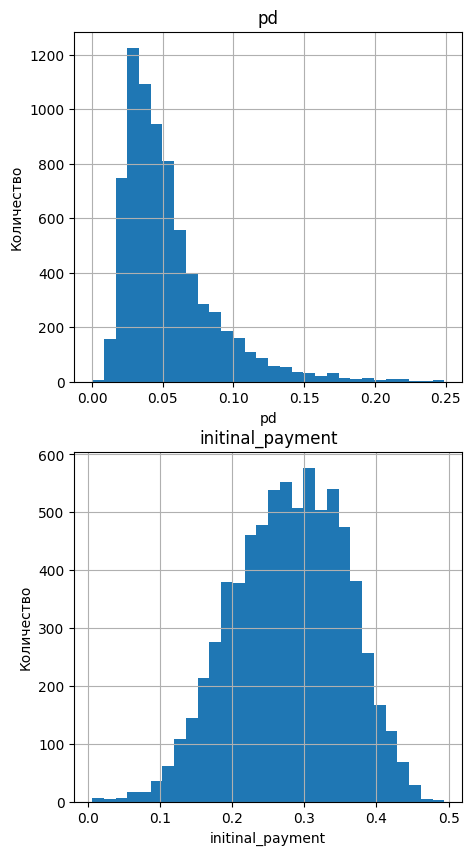

In [37]:
fig = plt.figure(figsize=(5, 10))

plt.subplot(2, 1, 1)
plt.hist(train_df['pd'], bins=30)
plt.title('pd')
plt.xlabel('pd')
plt.ylabel('Количество')
plt.grid()

plt.subplot(2, 1, 2)
plt.hist(train_df['initinal_payment'], bins=30)
plt.title('initinal_payment')
plt.xlabel('initinal_payment')
plt.ylabel('Количество')
plt.grid()

plt.show()

## Распределение признаков TRAIN в разрезе `delay`

<Figure size 500x1000 with 0 Axes>

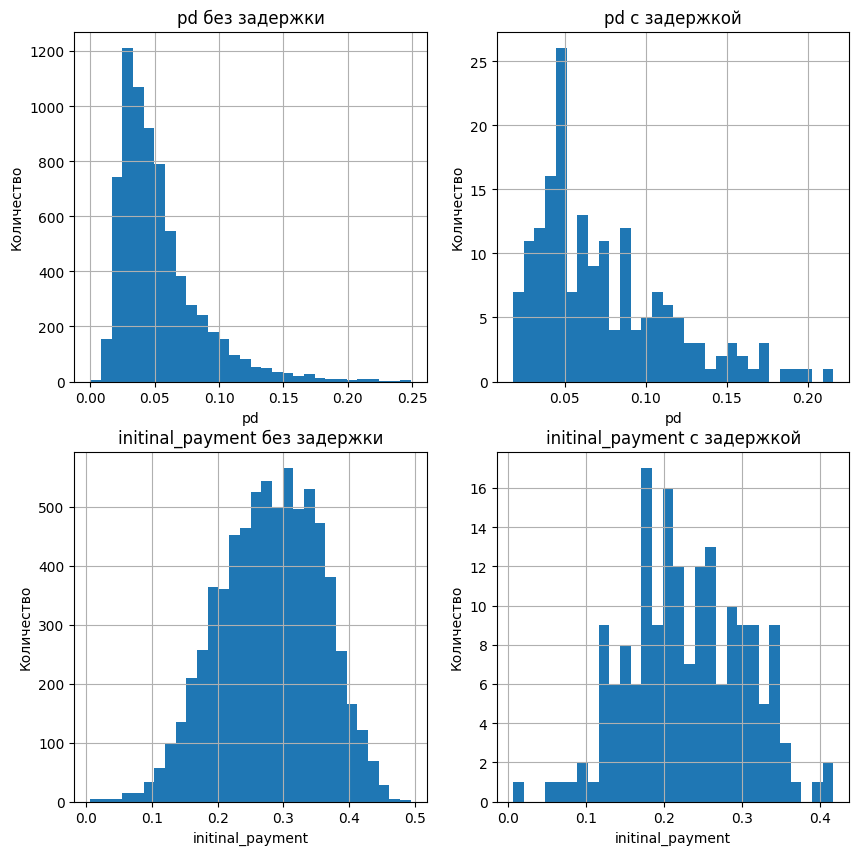

In [38]:
fig = plt.figure(figsize=(5, 10))

data = []
data.append(train_df[train_df['delay'] == 0])
data.append(train_df[train_df['delay'] == 1])

columns = ['pd', 'initinal_payment']

fig = plt.figure(figsize=(10, 10))

for i in range(2):
    for j, column in enumerate(columns):
        curr_data = data[i][column]
        plt.subplot(2, 2, j*2 + i + 1)
        plt.hist(curr_data, bins=30)
        if i == 0:
            plt.title(column+' без задержки')
        else: 
            plt.title(column+' с задержкой')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
plt.show()

Сравним распределения признаков в разрезе `delay` с помощью t-теста

$H_0$: средние значения распределений равны: $\mu_1 = \mu_2$

$H_1$: средние значения распределений различны: $\mu_1 \neq \mu_2$

`pd`

In [39]:
column = 'pd'
data1 = train_df.loc[train_df['delay'] == 0, column]
data2 = train_df.loc[train_df['delay'] == 1, column]
result = ttest_ind(data1, data2, equal_var=False)
print('Значение статистики =', result.statistic)
print('p-значение =', result.pvalue)

Значение статистики = -6.606196664319414
p-значение = 4.245338129653074e-10


`initinal_payment`

In [40]:
column = 'initinal_payment'
data1 = train_df.loc[train_df['delay'] == 0, column]
data2 = train_df.loc[train_df['delay'] == 1, column]
result = ttest_ind(data1, data2, equal_var=False)
print('Значение статистики =', result.statistic)
print('p-значение =', result.pvalue)

Значение статистики = 9.061877177472955
p-значение = 1.8076243986901582e-16


В обоих случаях имеем заметное различие средних

In [41]:
print(f"mean_pd_0 = {train_df.loc[train_df['delay'] == 0, 'pd'].mean()}")
print(f"mean_pd_1 = {train_df.loc[train_df['delay'] == 1, 'pd'].mean()}")
print(f"mean_ip_0 = {train_df.loc[train_df['delay'] == 0, 'initinal_payment'].mean()}")
print(f"mean_ip_1 = {train_df.loc[train_df['delay'] == 1, 'initinal_payment'].mean()}")

mean_pd_0 = 0.053101402524544185
mean_pd_1 = 0.073954802259887
mean_ip_0 = 0.2804561009817672
mean_ip_1 = 0.22894915254237289


Посмотрим на распределение принаков на плоскости

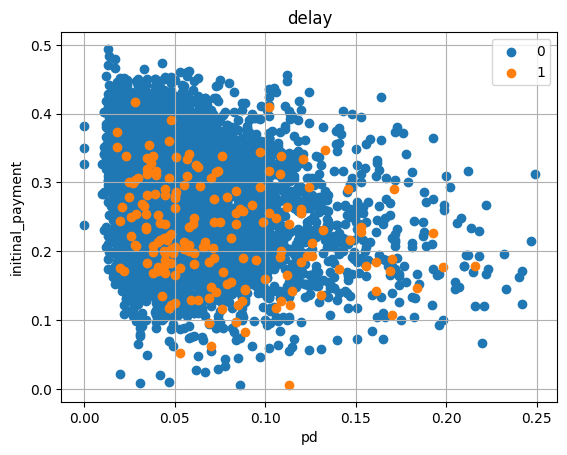

In [42]:
data = train_df
color_feature = 'delay'
feature_1 = 'pd'
feature_2 = 'initinal_payment'
plt.title(color_feature)
plt.xlabel(feature_1)
plt.ylabel(feature_2)
unique_values = data[color_feature].unique()
for value in unique_values:
    curr_data = data[data[color_feature] == value]
    plt.scatter(curr_data[feature_1], curr_data[feature_2], label=value)
plt.grid()
plt.legend()
plt.show()

Визуально классы плохо разделимы

In [43]:
train_df['delay'].value_counts(1)

0    0.975777
1    0.024223
Name: delay, dtype: float64

Если мы возьмем модель, которая будет одобрять все кредиты, то она она будет ошибаться в 2,4 % случаев, что слишком много, т.к. в условии требуется менее 1 % ошибок.

## Анализ корреляций тренировочной выборки

In [44]:
train_df.head()

,application_id,pd,initinal_payment,delay
0,1,0.054,0.290,0
1,2,0.138,0.183,0
2,3,0.135,0.244,0
3,4,0.042,0.271,0
4,5,0.058,0.174,0


In [45]:
interval_cols = ['pd', 'initinal_payment']

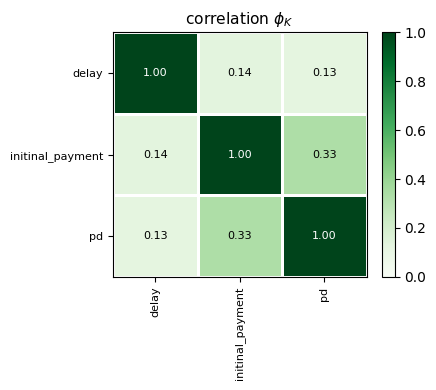

In [46]:
phik_overview = phik_matrix(train_df.drop(columns=['application_id']), \
                            interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=0.8,
    figsize=(4.5, 4)
) 

Целевой признак слабо скоррелирован с остальными признаками, что говорит об отсутствии линейной зависимости, но не об отсутствии зависимости вовсе.

Попробуем применить комбинацию признаков - сумму/произведение значений с разными коэффициентами/степенями.

In [47]:
def sum_func(x, y, koef1=0.5, koef2=0.5):
    return koef1 * x + koef2 * y

In [48]:
def prod_func(x, y, deg1=1, deg2=1):
    return x ** deg1 * y ** deg2

In [49]:
curr_df = train_df.drop(['application_id'], axis=1)
sum_koefs = [(1 - 0.1*i, 0.1*i) for i in range(-5, 15)]
prod_degs = [(1, 1), (1, 2), (2, 1), (0.5, 1), (1, 0.5), (0.25, 1), (1, 0.25), \
             (0.5, 0.5), (4, 1), (1, 4)]
print(len(sum_koefs))
print(len(prod_degs))
#Признаки суммы
for i in range(len(sum_koefs)):
    koefs = sum_koefs[i]
    curr_df['s '+str(round(koefs[0], 1))+', '+str(round(koefs[1], 1))] = \
    curr_df.apply(lambda x: sum_func(x['pd'], x['initinal_payment'], koef1=koefs[0], koef2=koefs[1]), axis=1)
 
 # Признаки произведения
for i in range(len(prod_degs)):
    degs = prod_degs[i]
    curr_df['p '+str(round(degs[0]))+', '+str(round(degs[1]))] = \
    curr_df.apply(lambda x: prod_func(x['pd'], x['initinal_payment'], deg1=degs[0], deg2=degs[1]), axis=1)
  
 #признак расстояние до центра кластера
curr_df['spec_one'] = curr_df.apply(lambda x: 2*(x['pd']-0.05)**2 + (x['initinal_payment']-0.25)**2, axis=1)

20
10


Полученный датафрейм с новыми признаками

In [50]:
display(curr_df)

,pd,initinal_payment,delay,"s 1.5, -0.5","s 1.4, -0.4","s 1.3, -0.3","s 1.2, -0.2","s 1.1, -0.1","s 1.0, 0.0","s 0.9, 0.1",...,"s -0.4, 1.4","p 1, 1","p 1, 2","p 2, 1","p 0, 1","p 1, 0","p 0, 0","p 4, 1","p 1, 4",spec_one
0,0.054,0.290,0,-6.400000e-02,-0.0404,-0.0168,0.0068,0.0304,0.054,0.0776,...,0.3844,0.015660,0.004541,0.000846,0.139797,0.039627,0.125140,2.465886e-06,0.000382,0.001632
1,0.138,0.183,0,1.155000e-01,0.1200,0.1245,0.1290,0.1335,0.138,0.1425,...,0.2010,0.025254,0.004621,0.003485,0.111537,0.090259,0.158915,6.636933e-05,0.000155,0.019977
2,0.135,0.244,0,8.050000e-02,0.0914,0.1023,0.1132,0.1241,0.135,0.1459,...,0.2876,0.032940,0.008037,0.004447,0.147902,0.094881,0.181494,8.104475e-05,0.000479,0.014486
3,0.042,0.271,0,-7.250000e-02,-0.0496,-0.0267,-0.0038,0.0191,0.042,0.0649,...,0.3626,0.011382,0.003085,0.000478,0.122682,0.030303,0.106686,8.432696e-07,0.000227,0.000569
4,0.058,0.174,0,1.387779e-17,0.0116,0.0232,0.0348,0.0464,0.058,0.0696,...,0.2204,0.010092,0.001756,0.000585,0.085390,0.037460,0.100459,1.969070e-06,0.000053,0.005904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7302,0.030,0.245,0,-7.750000e-02,-0.0560,-0.0345,-0.0130,0.0085,0.030,0.0515,...,0.3310,0.007350,0.001801,0.000220,0.101964,0.021106,0.085732,1.984500e-07,0.000108,0.000825
7303,0.090,0.295,0,-1.250000e-02,0.0080,0.0285,0.0490,0.0695,0.090,0.1105,...,0.3770,0.026550,0.007832,0.002389,0.161578,0.066328,0.162942,1.935495e-05,0.000682,0.005225
7304,0.032,0.311,0,-1.075000e-01,-0.0796,-0.0517,-0.0238,0.0041,0.032,0.0599,...,0.4226,0.009952,0.003095,0.000318,0.131537,0.023897,0.099760,3.261071e-07,0.000299,0.004369
7305,0.036,0.196,0,-4.400000e-02,-0.0280,-0.0120,0.0040,0.0200,0.036,0.0520,...,0.2600,0.007056,0.001383,0.000254,0.085375,0.023953,0.084000,3.292047e-07,0.000053,0.003308


Матрица корреляций нового датафрейма

In [51]:
interval_cols = curr_df.drop(columns=['delay']).columns.tolist()

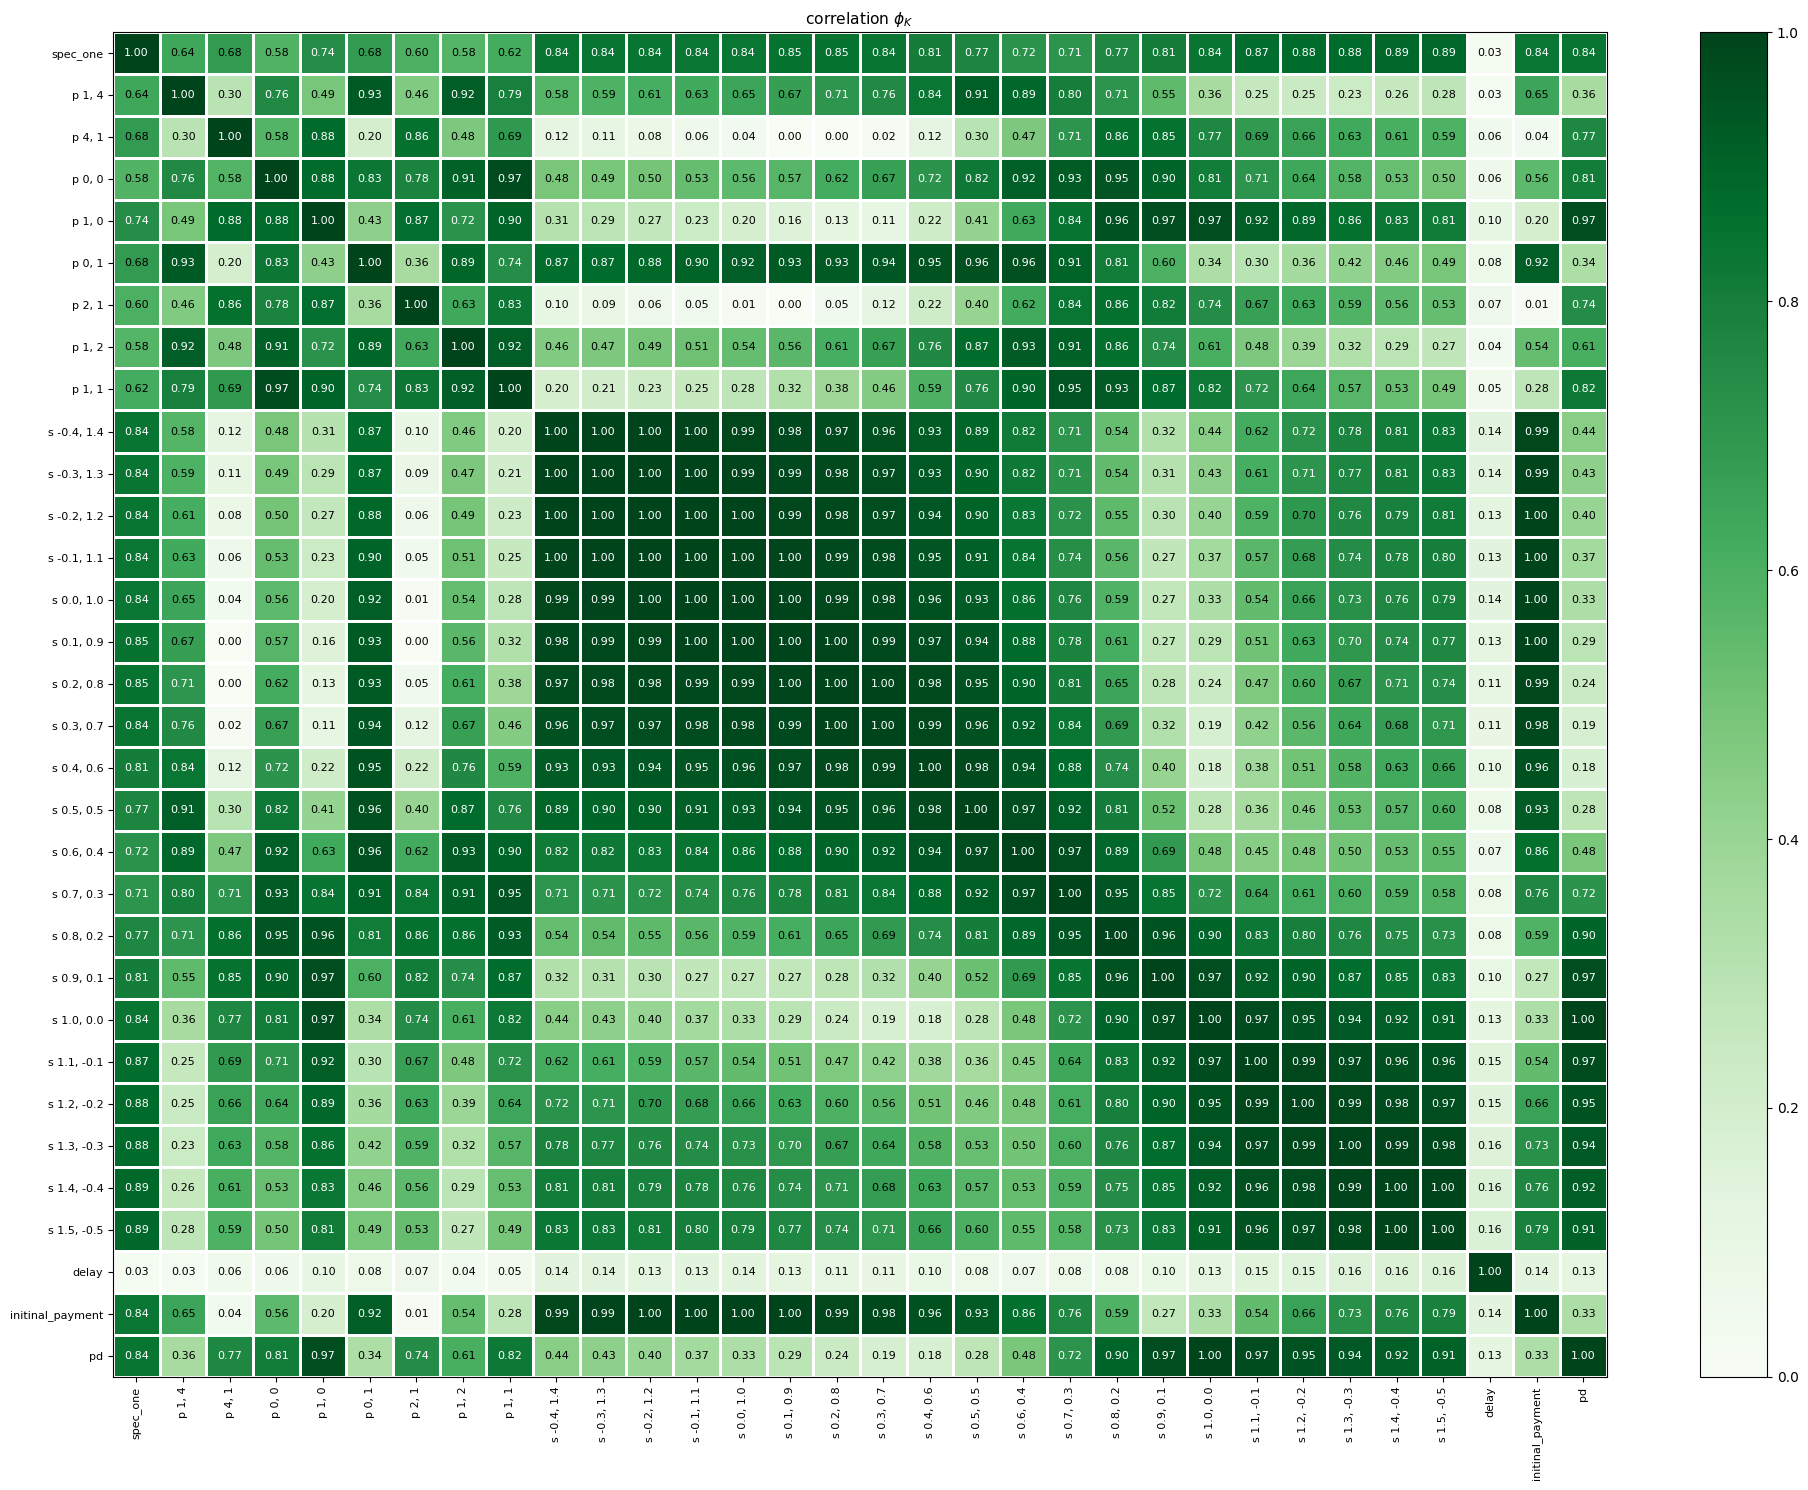

In [52]:
phik_overview = phik_matrix(curr_df, \
                            interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=0.8,
    figsize=(20, 15)
) 

У некоторых новых признаков корреляция с целевым чуть больше, чем у исходных, но она всё так же мала.

## Пайплайн

Для поиска наилучшей модели будем использовать пайплайн. Помимо списка параметров моделей понадобится также создать свою метрику, которая будет отображать, насколько модель удовлетворяет условиям задачи.

Условия на бинарный классификатор:
* precision >= 0.99
* recall максимален

In [53]:
def custom_metric(y_true, y_pred_proba, need_threshold=False):
    #Проверка наличия пропусков в векторах
    if np.any(np.isnan(y_pred_proba)):
        print('NaN in y_pred_proba')
        return 0
    if np.any(np.isnan(y_true)):
        print('NaN in y_true')
        return 0
    
    if y_pred_proba.ndim == 1:
        probas = y_pred_proba
    else:
        probas = y_pred_proba[:, 0]
    # Находим оптимальный порог для достижения precision >= 0.99 на этих прогнозах
    precisions, recalls, thresholds = \
    precision_recall_curve(y_true, probas, pos_label=0)

    precisions = np.array(precisions)
    recalls = np.array(recalls)

    valid_indices = np.where(precisions[:-1] >= 0.99)[0]

    if len(valid_indices) == 0:
        if need_threshold:
            return 0, -1
        else:
            return 0
        
    best_idx = valid_indices[np.argmax(recalls[valid_indices])]
    if np.isnan(recalls[best_idx]):
        if need_threshold:
            return 0, -1
        else:
            return 0
    if need_threshold:
        return recalls[best_idx], thresholds[best_idx]
    else:
        return recalls[best_idx]

In [54]:
custom_scorer = make_scorer(custom_metric, needs_proba=True)

Фиксируем параметр `RANDOM_STATE` для воспроизводимости

In [55]:
RANDOM_STATE = 42

Создаем пайплайн (в него также можно добавить предобработку данных, но она была проведена заранее)

In [56]:
num_columns = ['pd', 'initinal_payment']

`MinMaxScaler` для приведения значений числовых полей к отрезку [0, 1]

In [57]:
data_preprocessor = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [58]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(probability=True, random_state=RANDOM_STATE))
])

Список моделей и параметров для них

In [59]:
param_grid = []

Словарь для модели `LogisticRegression()`

In [60]:
param_grid.append(
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            penalty='l1'
        )],
        'models__C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 50, 70, 90, 100, 110, 130, 150, 180, 210, 240, 270, 300, 1000],
        'models__solver':['liblinear', 'saga'],
    })

Словарь для модели `SVC()`

In [61]:
param_grid.append(
    {
        'models': [SVC(probability=True,
            random_state=RANDOM_STATE
        )],
        'models__gamma': ['auto'],
        'models__kernel': ['rbf', 'linear'],
        'models__C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, \
                50, 70, 90, 100, 110, 130, 150, 180, 210, 240, 270, 300, 1000],
    })

Словарь для модели `XGBoost`

In [62]:
param_grid.append(
    {
        'models': [xgb.XGBClassifier(max_depth=3)],
        'models__learning_rate': np.arange(0.05, 1, 0.05),
        'models__max_depth': np.arange(3, 10, 1),
        'models__n_estimators': np.arange(50, 200, 50),
    }
)

Словарь для модели `LightGBM`

In [63]:
param_grid.append(
    {
        'models': [lgb.LGBMClassifier(random_state=RANDOM_STATE,
                                     scale_pos_weight=50)],
        'models__n_estimators': [100, 200, 300],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__reg_alpha': [0.1, 1],
        'models__reg_lambda': [0.1, 1],
    }
)

Словарь для модели `DummyClassifier()`

In [64]:
param_grid.append(
    {
        'models': [DummyClassifier(strategy='prior')],
    })

Реализация расчетов модели для всех вариантов пайплайна

In [65]:
searcher = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    random_state=RANDOM_STATE,
    scoring=custom_scorer,
    n_jobs=-1,
    n_iter=520
)

Отделяем целевой признак от тренировочных данных, удаляем столбец `application_id`

In [66]:
train_df.head()

,application_id,pd,initinal_payment,delay
0,1,0.054,0.290,0
1,2,0.138,0.183,0
2,3,0.135,0.244,0
3,4,0.042,0.271,0
4,5,0.058,0.174,0


In [67]:
X_train = train_df.drop(columns=['application_id', 'delay'])
y_train = train_df['delay']

In [68]:
display(X_train.head())
print(type(X_train))

,pd,initinal_payment
0,0.054,0.290
1,0.138,0.183
2,0.135,0.244
3,0.042,0.271
4,0.058,0.174


<class 'pandas.core.frame.DataFrame'>


In [69]:
display(y_train.head())
print(type(y_train))

0    0
1    0
2    0
3    0
4    0
Name: delay, dtype: int64

<class 'pandas.core.series.Series'>


Расчеты выбранной метрики на всех моделях, параметры которых есть в `parameters_grid`, вывод параметров и метрики для лучшей модели

In [70]:
searcher.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', searcher.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', searcher.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['pd',
                                                   'initinal_payment'])])),
                ('models',
                 SVC(C=180, gamma='auto', kernel='linear', probability=True,
                     random_state=42))])
Метрика лучшей модели на кросс-валидации: 0.41669004207573634


Вывод списка результатов работы всех моделей, отсортированного по значению выбранной метрики на кросс-валидации (Столбец `mean_test_score`)

In [71]:
results = pd.DataFrame(searcher.cv_results_)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results.sort_values(by='rank_test_score'))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__solver,param_models__C,param_models,param_models__kernel,param_models__gamma,param_models__n_estimators,param_models__max_depth,param_models__learning_rate,param_models__reg_lambda,param_models__reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
73,0.167000,0.005967,0.010800,9.797249e-04,NaN,180,"SVC(C=180, gamma='auto', kernel='linear', prob...",linear,auto,NaN,NaN,NaN,NaN,NaN,"{'models__kernel': 'linear', 'models__gamma': ...",0.301543,0.574334,0.598878,0.598177,0.010519,0.416690,0.232041,1
77,0.189400,0.023406,0.012000,2.529922e-03,NaN,240,"SVC(C=180, gamma='auto', kernel='linear', prob...",linear,auto,NaN,NaN,NaN,NaN,NaN,"{'models__kernel': 'linear', 'models__gamma': ...",0.305750,0.504208,0.443899,0.618513,0.009116,0.376297,0.209475,2
65,0.173600,0.011430,0.010600,1.200223e-03,NaN,100,"SVC(C=180, gamma='auto', kernel='linear', prob...",linear,auto,NaN,NaN,NaN,NaN,NaN,"{'models__kernel': 'linear', 'models__gamma': ...",0.019635,0.525947,0.425666,0.021038,0.580645,0.314586,0.245343,3
50,0.339799,0.012156,0.043400,2.498276e-03,NaN,1,"SVC(C=180, gamma='auto', kernel='linear', prob...",rbf,auto,NaN,NaN,NaN,NaN,NaN,"{'models__kernel': 'rbf', 'models__gamma': 'au...",0.254558,0.173212,0.406031,0.016129,0.428471,0.255680,0.152741,4
51,0.165800,0.002926,0.011000,1.264819e-03,NaN,1,"SVC(C=180, gamma='auto', kernel='linear', prob...",linear,auto,NaN,NaN,NaN,NaN,NaN,"{'models__kernel': 'linear', 'models__gamma': ...",0.283310,0.484572,0.368864,0.085554,0.016830,0.247826,0.174155,5
69,0.169600,0.004271,0.010200,3.998518e-04,NaN,130,"SVC(C=180, gamma='auto', kernel='linear', prob...",linear,auto,NaN,NaN,NaN,NaN,NaN,"{'models__kernel': 'linear', 'models__gamma': ...",0.422160,0.417952,0.281907,0.017532,0.009116,0.229734,0.183781,6
57,0.160800,0.002315,0.010200,4.000426e-04,NaN,30,"SVC(C=180, gamma='auto', kernel='linear', prob...",linear,auto,NaN,NaN,NaN,NaN,NaN,"{'models__kernel': 'linear', 'models__gamma': ...",0.488780,0.514727,0.056101,0.026648,0.027349,0.222721,0.228224,7
43,0.159999,0.003098,0.011000,1.095453e-03,NaN,0.01,"SVC(C=180, gamma='auto', kernel='linear', prob...",linear,auto,NaN,NaN,NaN,NaN,NaN,"{'models__kernel': 'linear', 'models__gamma': ...",0.330295,0.000000,0.011220,0.007714,0.708976,0.211641,0.278556,8
46,0.318000,0.011781,0.038600,1.624813e-03,NaN,0.1,"SVC(C=180, gamma='auto', kernel='linear', prob...",rbf,auto,NaN,NaN,NaN,NaN,NaN,"{'models__kernel': 'rbf', 'models__gamma': 'au...",0.009818,0.360449,0.002104,0.020337,0.555400,0.189621,0.227651,9
53,0.158800,0.004400,0.010200,4.002812e-04,NaN,3,"SVC(C=180, gamma='auto', kernel='linear', prob...",linear,auto,NaN,NaN,NaN,NaN,NaN,"{'models__kernel': 'linear', 'models__gamma': ...",0.003506,0.484572,0.349930,0.020337,0.088359,0.189341,0.193000,10


В таблице выше можем видеть 10 лучших моделей по средним значениям выбранной метрики на кросс-валидации. У них всех очень высокое стандартное отклонение этого значения (Столбец `std_test_score`), т.е. условие `precision`>0.99 очень сильно сокращает список возможных порогов для классификации. Из-за чего, например, у лучшей модели значения метрики изменяются от 0.01 до 0.6. У худших моделей, наоборот, метрика всегда 0, т.к. ни при каком пороге не выполняется условие `precision`>0.99.


## Выбор лучшей модели

Теперь возьмем 10 лучших моделей (все оказались моделями `Support Vector Classification` (`SVC`)) и посмотрим на их значения метрики уже не на кросс валидации, а на всем тренировочном датасете.

In [72]:
models = [
    SVC(C=180, gamma='auto', kernel='linear', probability=True, random_state=42),
    SVC(C=240, gamma='auto', kernel='linear', probability=True, random_state=42),
    SVC(C=100, gamma='auto', kernel='linear', probability=True, random_state=42),
    SVC(C=1, gamma='auto', kernel='rbf', probability=True, random_state=42),
    SVC(C=1, gamma='auto', kernel='linear', probability=True, random_state=42),
    SVC(C=130, gamma='auto', kernel='linear', probability=True, random_state=42),
    SVC(C=30, gamma='auto', kernel='linear', probability=True, random_state=42),
    SVC(C=0.01, gamma='auto', kernel='linear', probability=True, random_state=42),
    SVC(C=0.1, gamma='auto', kernel='rbf', probability=True, random_state=42),
    SVC(C=3, gamma='auto', kernel='linear', probability=True, random_state=42)
]

In [73]:
model_names = [
    "SVC(C=180, gamma='auto', kernel='linear', probability=True, random_state=42)",
    "SVC(C=240, gamma='auto', kernel='linear', probability=True, random_state=42)",
    "SVC(C=100, gamma='auto', kernel='linear', probability=True, random_state=42)",
    "SVC(C=1, gamma='auto', kernel='rbf', probability=True, random_state=42)",
    "SVC(C=1, gamma='auto', kernel='linear', probability=True, random_state=42)",
    "SVC(C=130, gamma='auto', kernel='linear', probability=True, random_state=42)",
    "SVC(C=30, gamma='auto', kernel='linear', probability=True, random_state=42)",
    "SVC(C=0.01, gamma='auto', kernel='linear', probability=True, random_state=42)",
    "SVC(C=0.1, gamma='auto', kernel='rbf', probability=True, random_state=42)",
    "SVC(C=3, gamma='auto', kernel='linear', probability=True, random_state=42)"
]

In [74]:
metric_avg = []
metric_gen = []

In [75]:
for i in range(len(models)):
    model = models[i]
    model_name = model_names[i]
    y_true = y_train
    model.fit(X_train, y_train)
    print(model_name)
    y_pred_proba = model.predict_proba(X_train)
    df = pd.DataFrame(data={'y_pred_proba_0':y_pred_proba[:, 0], \
                'y_pred_proba_1':y_pred_proba[:, 1], 'y_true':y_true})

    metric, threshold = custom_metric(y_true, y_pred_proba, need_threshold=True)
    metric_gen.append(metric)
    print('Значения метрики и выбранный порог для классификации:')
    print(custom_metric(y_true, y_pred_proba, need_threshold=True))
    y_pred = [0 if y_pred_proba[i][0] >= threshold else 1 \
              for i in range(len(y_pred_proba))]
    df = pd.DataFrame(data={'y_true':y_true, 'y_pred':y_pred})
    precision = precision_score(y_true, y_pred, pos_label=0)
    recall = recall_score(y_true, y_pred, pos_label=0)

    print('Значения precison и recall')
    print(precision, recall)
    svc = models[i]
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_val_score(svc, X_train, y_train, cv=cv, scoring=custom_scorer)
    print('Значения метрики на кросс-валидации')
    print(scores)
    print('Среднее значение на кросс-валидации')
    print(sum(scores)/len(scores))
    metric_avg.append(sum(scores)/len(scores))
    print()
    print()

SVC(C=180, gamma='auto', kernel='linear', probability=True, random_state=42)
Значения метрики и выбранный порог для классификации:
(0.3945301542776999, 0.9752635414176392)
Значения precison и recall
0.9901443153819077 0.3945301542776999
Значения метрики на кросс-валидации
[0.00490884 0.         0.00911641 0.0112202  0.72931276]
Среднее значение на кросс-валидации
0.1509116409537167


SVC(C=240, gamma='auto', kernel='linear', probability=True, random_state=42)
Значения метрики и выбранный порог для классификации:
(0.0019635343618513326, 0.993286338849698)
Значения precison и recall
1.0 0.0019635343618513326
Значения метрики на кросс-валидации
[0.00490884 0.         0.00631136 0.02244039 0.34992987]
Среднее значение на кросс-валидации
0.0767180925666199


SVC(C=100, gamma='auto', kernel='linear', probability=True, random_state=42)
Значения метрики и выбранный порог для классификации:
(0.27223001402524544, 0.9766239220510097)
Значения precison и recall
0.9903061224489796 0.272230014025245

In [76]:
best_idx = metric_gen.index(max(metric_gen))
print('Лучшая модель по метрике на тренировочной выборке:')
print(model_names[best_idx])
print('Метрика на всей выборке:')
print(metric_gen[best_idx])
print('Метрика на кросс-валидации:')
print(metric_avg[best_idx])

Лучшая модель по метрике на тренировочной выборке:
SVC(C=1, gamma='auto', kernel='linear', probability=True, random_state=42)
Метрика на всей выборке:
0.45876577840112204
Метрика на кросс-валидации:
0.1488078541374474


## Предсказание на тестовой выборке

Теперь применим эту модель для тестовой выборки:

Нужно оставить только скоринг

In [77]:
test_df = test_df[test_df['stage'] == 'full']
display(test_df)

,id,pd,initinal_payment,stage,status
2,7310,0.036,0.330,full,DECLINE
3,7311,0.044,0.168,full,DECLINE
5,7313,0.040,0.208,full,DECLINE
6,7314,0.062,0.211,full,DECLINE
7,7315,0.048,0.319,full,DECLINE
...,...,...,...,...,...
994,8302,0.143,0.292,full,DECLINE
995,8303,0.173,0.324,full,DECLINE
997,8305,0.069,0.325,full,DECLINE
998,8306,0.061,0.282,full,DECLINE


Оставим только поля для модели, т.е. `pd` и `initinal_payment`

In [78]:
new_df = test_df.reset_index(drop=True)
X_test = new_df.loc[:, ['pd', 'initinal_payment']]
display(X_test)
display(new_df)

,pd,initinal_payment
0,0.036,0.330
1,0.044,0.168
2,0.040,0.208
3,0.062,0.211
4,0.048,0.319
...,...,...
815,0.143,0.292
816,0.173,0.324
817,0.069,0.325
818,0.061,0.282


,id,pd,initinal_payment,stage,status
0,7310,0.036,0.330,full,DECLINE
1,7311,0.044,0.168,full,DECLINE
2,7313,0.040,0.208,full,DECLINE
3,7314,0.062,0.211,full,DECLINE
4,7315,0.048,0.319,full,DECLINE
...,...,...,...,...,...
815,8302,0.143,0.292,full,DECLINE
816,8303,0.173,0.324,full,DECLINE
817,8305,0.069,0.325,full,DECLINE
818,8306,0.061,0.282,full,DECLINE


Обучим лучшую модель на тренировочных данных и предскажем признак на тестовых

In [79]:
best_model = SVC(C=1, gamma='auto', kernel='linear', probability=True, random_state=42)
best_model.fit(X_train, y_train)

#на тренировочной
print('Метрика и порог для предсказаний на тренировочной выборке:')
y_pred_proba = best_model.predict_proba(X_train)
metric, threshold = custom_metric(y_true, y_pred_proba, need_threshold=True)
print(metric, threshold)
#на тестовой
y_pred_proba = best_model.predict_proba(X_test)
y_pred = [0 if y_pred_proba[i][0] >= threshold else 1 \
              for i in range(len(y_pred_proba))]
new_df['model'] = pd.Series(y_pred)
print()
print('Полученный датафрейм с предсказанными значениями')
display(new_df)


Метрика и порог для предсказаний на тренировочной выборке:
0.45876577840112204 0.9780558926695779

Полученный датафрейм с предсказанными значениями


,id,pd,initinal_payment,stage,status,model
0,7310,0.036,0.330,full,DECLINE,0
1,7311,0.044,0.168,full,DECLINE,1
2,7313,0.040,0.208,full,DECLINE,1
3,7314,0.062,0.211,full,DECLINE,1
4,7315,0.048,0.319,full,DECLINE,0
...,...,...,...,...,...,...
815,8302,0.143,0.292,full,DECLINE,1
816,8303,0.173,0.324,full,DECLINE,1
817,8305,0.069,0.325,full,DECLINE,1
818,8306,0.061,0.282,full,DECLINE,1


In [80]:
new_df['status'].value_counts()

DECLINE    581
APPROVE    239
Name: status, dtype: int64

Заменим значения в столбце `status` на числовые по аналогии со столбцом `model`: 

DECLINE -> 1, APPROVE -> 0


In [81]:
new_df['status'] = new_df.apply(lambda x: 1 if x['status']=='DECLINE' else \
                                (0 if x['status'] == 'APPROVE' else x['status']), axis=1)

Сравним числа нулей и единиц в столбцах `status` и `model`:

In [82]:
display(new_df['status'].value_counts())
display(new_df['model'].value_counts())

1    581
0    239
Name: status, dtype: int64

1    455
0    365
Name: model, dtype: int64

0 - модель предсказала, что клиент вернет кредит

1 - модель предсказала, что клиент не вернет кредит

Как можем видеть, построенная модель выявила больше клиентов, которые потенциально вернут кредит по ипотеке, чем СПР, что и требовалось в задании.

# Итоговый код для создания тестового датасета

In [83]:
application = pd.read_csv('./БД/spr_application.csv', sep=';')
request = pd.read_csv('./БД/spr_request.csv', sep=';')
features = pd.read_csv('./БД/spr_features.csv', sep=';')

На Python

In [84]:
df = pd.merge(request, features, how='left', left_on='spr_features_id', right_on='id')\
.sort_values(by='application_id').dropna().reset_index(drop=True).loc[:, ['application_id', 'pd', 'initinal_payment', 'status']]

In [85]:
display(df)

,application_id,pd,initinal_payment,status
0,7310,0.036,0.330,DECLINE
1,7311,0.044,0.168,DECLINE
2,7313,0.040,0.208,DECLINE
3,7314,0.062,0.211,DECLINE
4,7315,0.048,0.319,DECLINE
...,...,...,...,...
815,8302,0.143,0.292,DECLINE
816,8303,0.173,0.324,DECLINE
817,8305,0.069,0.325,DECLINE
818,8306,0.061,0.282,DECLINE


SQL запрос

SELECT 

    r.application_id,     
    f.pd,            
    f.initinal_payment,
    r.status
FROM 

    spr_request r
LEFT JOIN 

    spr_features f
ON 

    r.spr_features_id = f.id
WHERE 

    f.pd IS NOT NULL
    AND f.initinal_payment IS NOT NULL
ORDER BY 

    r.application_id